# Gumbel-Softmax - New feature
This notebook showcases a new feature introduced in version 0.6, Gumbel-Softmax activations!

**Structure of the notebook:**

1. A quick recap on categorical feature synthesis
2. Softmax and the Gumbel-Softmax activation
3. Synthesized categorical features comparison
    * Previous version
    * New version

## A quick recap on categorical feature synthesis
Before synthesizing we typically preprocess our features. In the case of categorical features, one-hot encodings are frequently used in order to transform discrete features into sparse blocks of 1's and 0's. Converting symbolic inputs like categorical features to sparse arrays allows neural network (NN) models to handle the data similarly to very different feature formats like numerical continuous features.

An example:
* Before one-hot encoding:

<style>
th {
  padding-top: 5px;
  padding-right: 10px;
  padding-bottom: 5px;
  padding-left: 10px;
}
</style>

| ID | Gender | AgeRange |
| :------------: | :-------:  | :-------:  |
| 1 | Male | 20-29 |
| 2 | Female | 10-19 |

* After one-hot encoding:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 1 | 0 | 0 | 1 |
| 2 | 0 | 1 | 1 | 0 |

GANs attempt to synthesize these sparse distributions as they appear on real data. However, despite the input categorical features having a sparse format, NN classifiers learn __[logits](https://en.wikipedia.org/wiki/Logit)__, non-normalized probability distributions, for each class represented in the one-hot encoded input. Without activation layers that can handle this output, you might get synthetic records looking something like this:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 0.867 | 0.622 | -0.155 | 0.855 |
| 2 | 0.032 | 1.045 | 0.901 | -0.122 |

This looks messy; leaves you with the job of inferring a sensible output (p.e. use the class with highest activation) and also is a potential flag for a GAN discriminator to identify fake samples.

Let's see what Gumbel-Softmax is and what it can do about to fix the issue!

## Softmax and the Gumbel-Softmax activation
Softmax is a differentiable family of functions that map an array of logits to probabilities, i.e. values are bounded in the range $[0, 1]$ and sum to 1.
These are often used for turning logits into probability distributions from which we can sample. However these samples can't help us in gradient descent model learning because they are obtained from a random process (no relation with the model's parameters).

The Gumbel-Softmax (GS) is a special kind of Softmax function that got introduced in 2016 (fun fact: coincidentally it was proposed in the same time by two independent teams) __[\[1](https://arxiv.org/abs/1611.00712)__, __[2\]](https://arxiv.org/abs/1611.01144)__. It works like a continuous approximation of Softmax. Instead of using logits directly __[Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution)__ noise is added before the softmax operation so that our model is outputting a combination from a deterministic component, parameterized by the mean and the variance of the categorical distribution, and a stochastic component, the Gumbel noise, which is just helping us sample without adding bias to the process.

A temperature parameter, usually called tau or lambda and defined in $]0, inf[$ is used to tune this distribution between the true categorical distribution and a uniform distribution respectively. This parameter is usually kept close to 0.

## Synthesized categorical features comparison
Now we are moving to a comparison of results before/after GS activation was added. We will do this by first looking at raw (as they leave the generator and before pre-processing) samples format and synthetic samples categorical distributions with histograms.
For this comparison we will leverage the WGAN with Gradient Penalty implementation of the library on the adult dataset. The available snippets should reproduce the results but the takeaways are fully delivered on the cached results of this notebook.
Since the new feature is already implemented in our WGAN with Gradient Penalty implementation, we will inherit and make a very simple override so that we use a generator without the GS activation.

### Raw sample format comparison
This comparison is similar to the examples in the introduction section. We are looking for one-hot encoded features as the samples leave the generator.

In [1]:
from pmlb import fetch_data

from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

data = fetch_data('adult')
num_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_cols = ['workclass','education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'native-country', 'target']


# WGAN_GP training
# Defining the training parameters of WGAN_GP

noise_dim = 128
dim = 128
batch_size = 500

log_step = 100
epochs = 300
learning_rate = 1e-5
beta_1 = 0.5
beta_2 = 0.9

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

n_discriminator = 3
sample_size = 1500

In [2]:
# Mimicking the previous WGAN_GP implementation
class OldWGAN_GP(WGAN_GP):
    """The simple override of the define_gan below blocks the generator from plugging in the GS activation layer.
    This makes it equivalent to the previous implementation.
    The source code will help you understanding how it works"""
    def define_gan(self, activation_info = None):
        super().define_gan(activation_info=None)

In [3]:
from tensorflow.random import uniform
from tensorflow.dtypes import float32

# Random noise for sampling both generators
noise = uniform([sample_size, noise_dim], dtype=float32)

print('Previous WGAN_GP version train')
old_wgan = OldWGAN_GP(gan_args, n_discriminator)
old_wgan.train(data, train_args, num_cols, cat_cols)

print('New WGAN_GP version train')
new_wgan = WGAN_GP(gan_args, n_discriminator)
new_wgan.train(data, train_args, num_cols, cat_cols)


Previous WGAN_GP version train


 50%|█████     | 1/2 [00:05<00:05,  5.79s/it]

Epoch: 0 | disc_loss: 185.8821563720703 | gen_loss: -0.03987611457705498


100%|██████████| 2/2 [00:08<00:00,  4.40s/it]

Epoch: 1 | disc_loss: 79.96199035644531 | gen_loss: -0.001384154660627246
New WGAN_GP version train



 50%|█████     | 1/2 [00:06<00:06,  6.43s/it]

Epoch: 0 | disc_loss: 230.9500732421875 | gen_loss: -0.038387399166822433


100%|██████████| 2/2 [00:09<00:00,  4.91s/it]

Epoch: 1 | disc_loss: 109.43257141113281 | gen_loss: -0.020640568807721138


In [4]:
# Sample both generators - We use raw samples (before inverting the data preprocessing) in order to compare the samples as they are returned by the generator
old_raw_samples = old_wgan.generator(noise, training=False).numpy()
new_raw_samples = new_wgan.generator(noise, training=False).numpy()

In [5]:
from pandas import DataFrame

# Get the input/output data preprocessor map to help us isolate the categorical feats output
preprocessor_map = new_wgan.processor.col_transform_info

# Isolate the categorical features and get the feature names
n_num_feats = len(preprocessor_map.numerical.feat_names_in)
cat_out_names = preprocessor_map.categorical.feat_names_out

# Place the categorical parts of the samples in Pandas DataFrames
old_cat_raw = DataFrame(old_raw_samples[:,n_num_feats:], columns=cat_out_names)
new_cat_raw = DataFrame(new_raw_samples[:,n_num_feats:], columns=cat_out_names)

In [6]:
# Inspect the old categorical outputs of the generator
old_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,0.091294,-0.128263,0.396440,-0.053838,0.212083,0.091714,0.021552,-0.128664,0.138277,0.160142,...,0.120565,-0.075678,-0.037093,0.048407,0.104094,-0.029971,-0.270972,0.251321,-0.274399,0.283359
1,0.010785,-0.105210,0.337652,-0.045757,0.196224,0.151556,0.116179,-0.189613,0.284733,-0.072774,...,-0.101111,0.092322,-0.005980,0.199971,0.118854,-0.086566,-0.225938,0.259777,-0.149349,0.340764
2,0.069573,-0.212167,0.391546,-0.151277,0.292299,-0.031677,0.141168,-0.169125,0.327520,-0.039255,...,-0.100964,0.073956,0.044180,0.171475,0.241521,0.042241,-0.239880,0.340442,-0.186446,0.316688
3,0.174410,-0.120761,0.430975,-0.189371,0.239266,-0.121954,0.196014,-0.186778,0.361448,-0.104840,...,0.032779,0.058830,-0.009135,0.102690,0.216104,-0.123154,-0.319918,0.295589,-0.276266,0.265141
4,0.052058,-0.183792,0.432356,-0.059743,0.293950,-0.005072,0.204160,-0.167234,0.256697,0.220048,...,0.036888,0.041552,-0.042502,0.131966,0.341256,-0.012532,-0.227650,0.224236,-0.326795,0.241426


In [7]:
# Inspect the new categorical outputs of the generator
new_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Synthesized samples comparison
In this comparison we are looking at histograms of the categorical distributions of the synthetic samples of both the old and the new generators.
We selected the workclass feature just because the number of classes seemed interesting for the visual comparison.
Feel free to adapt and perform your own comparisons, maybe even with other GANs available in our repository, with different parameters or just different runs.

In [17]:
# Sample the real dataset and the generators
real_samples = data.sample(n=sample_size)
old_samples = old_wgan.sample(sample_size)
new_samples = new_wgan.sample(sample_size)

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00, 68.95it/s]


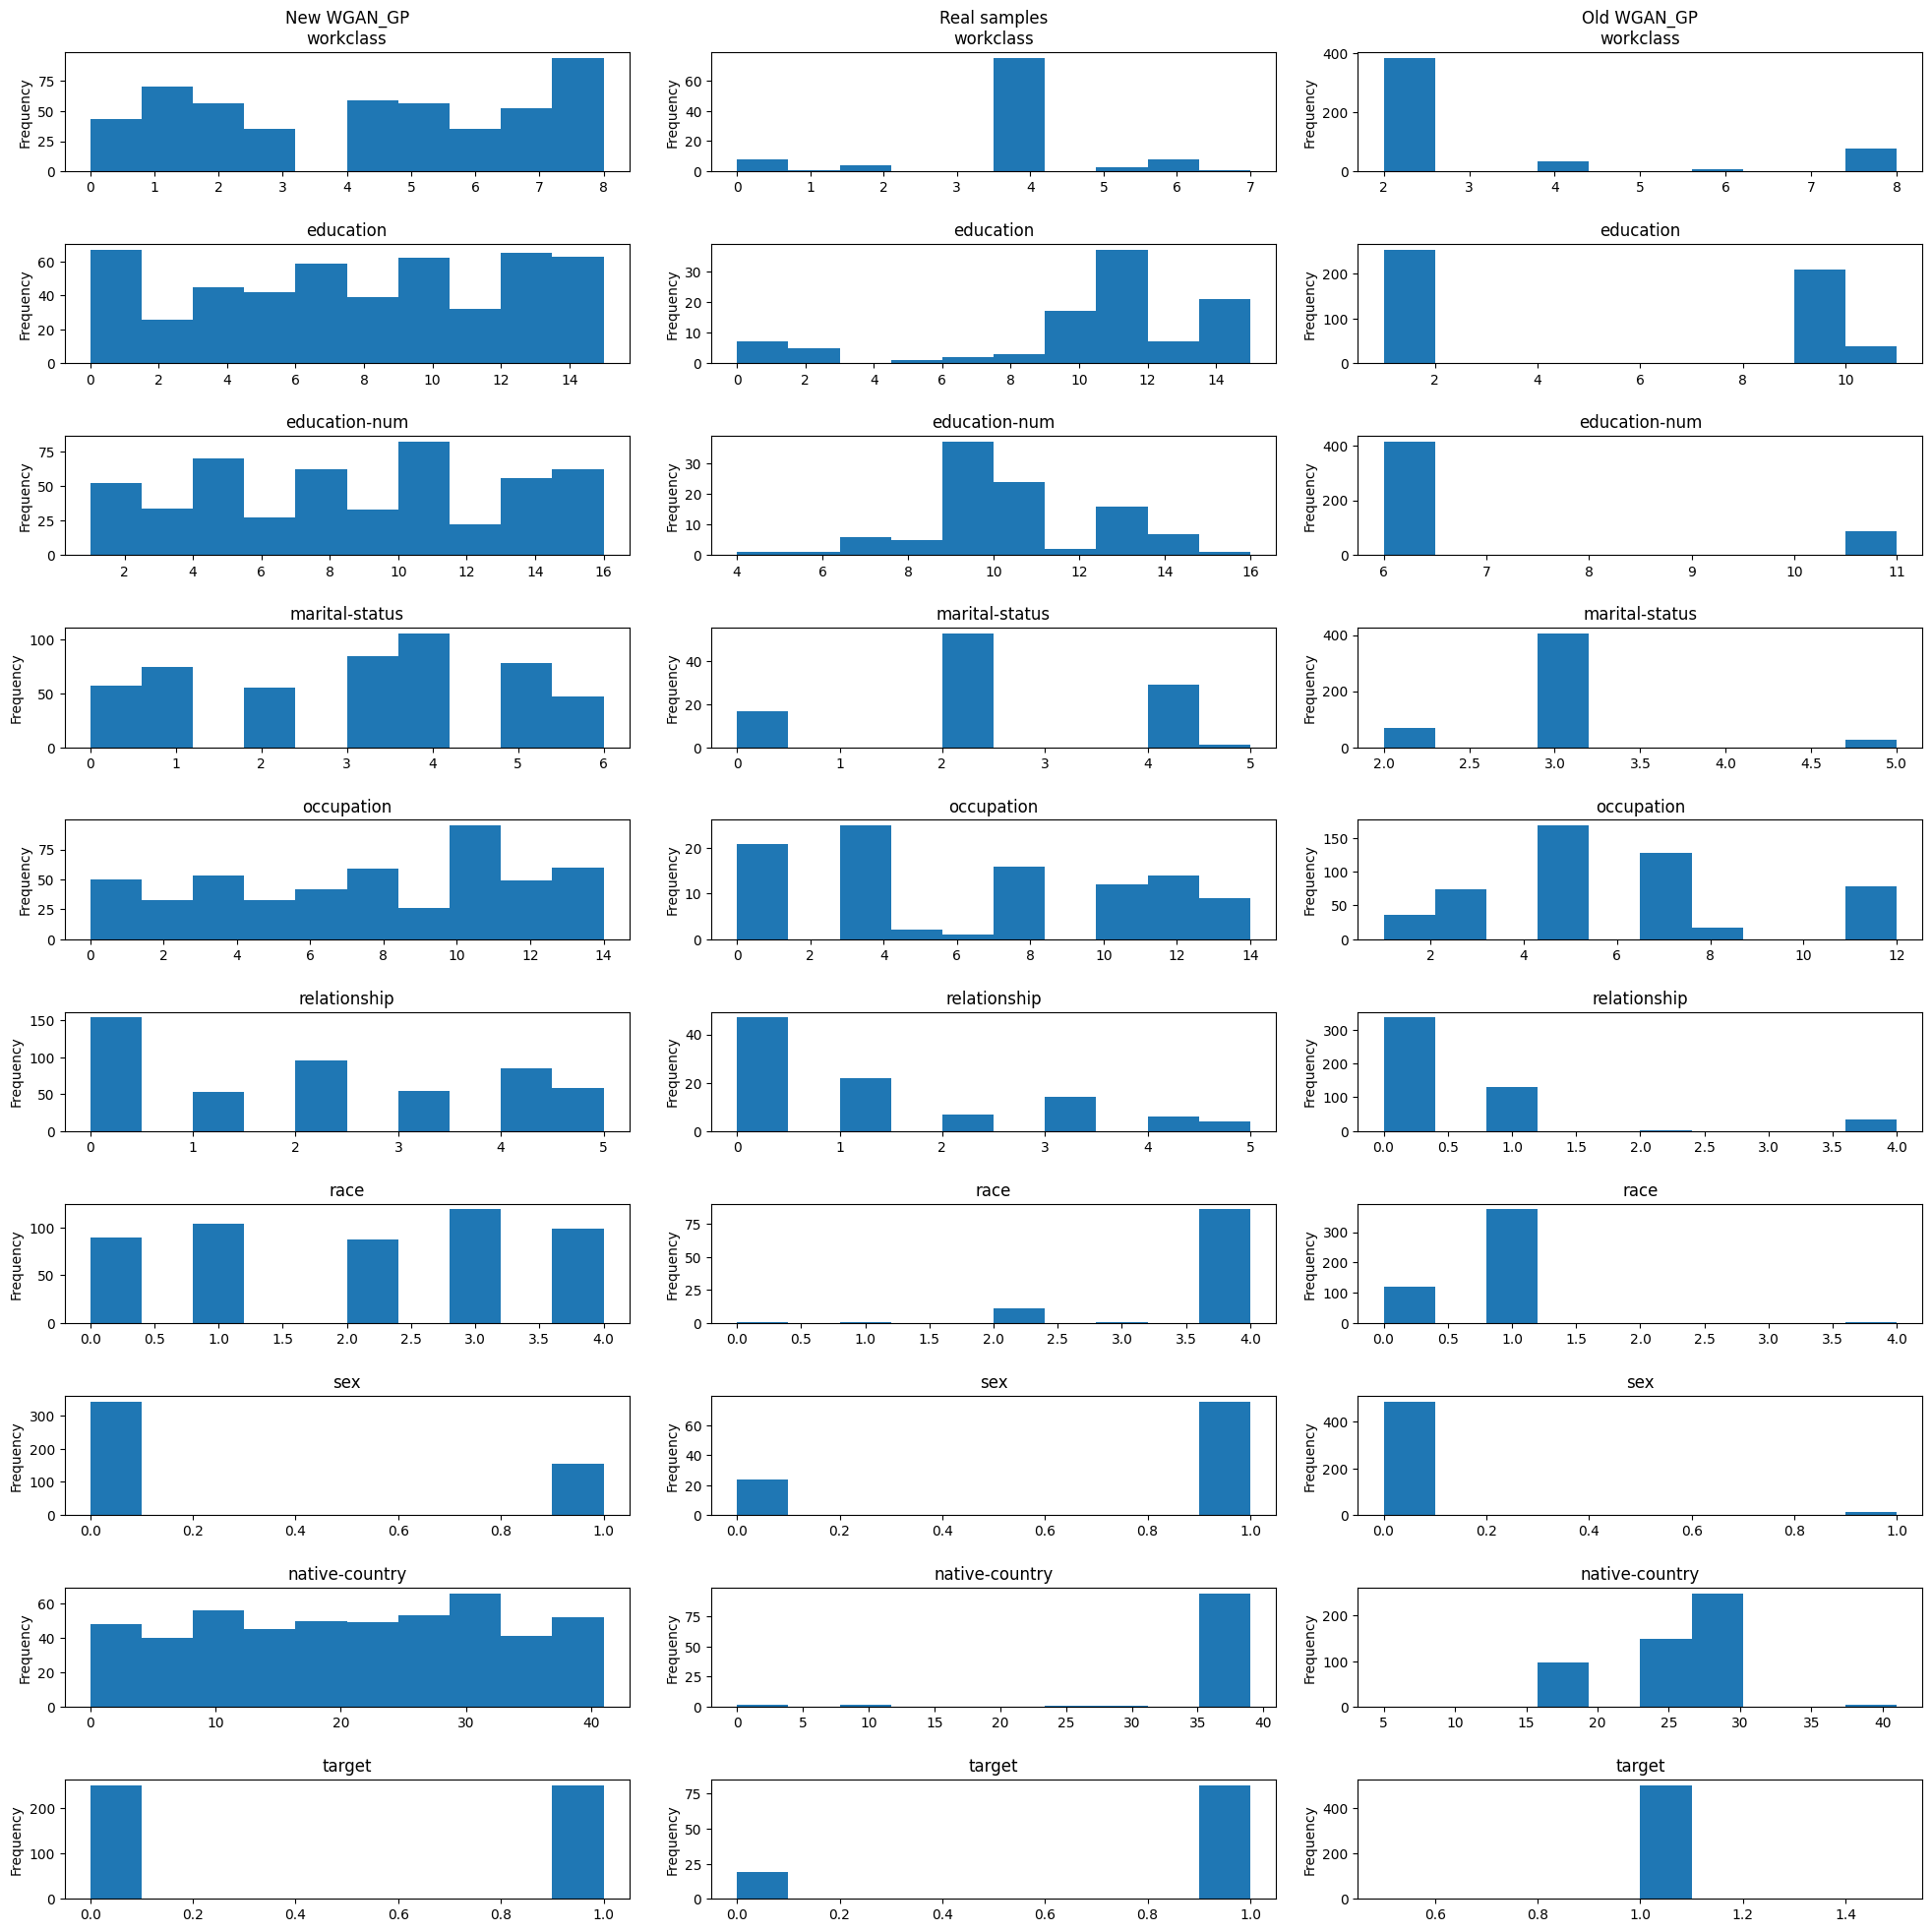

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(cat_cols), ncols=3, figsize= (20,20))
for i, feat in enumerate(cat_cols):
    for j, (name, samples) in enumerate({'New WGAN_GP': new_samples, 'Real samples': real_samples, 'Old WGAN_GP': old_samples}.items()):
        samples[feat].plot(kind='hist', ax=axes[i, j], title=(name +'\n' if i==0 else '') + feat)
fig.tight_layout(pad=2.0)
plt.show()

Did you notice the difference of the Gumbel-Softmax in the output of the generators?
By default this feature is implemented in all the regular generators.

Enjoy the improved categorical generation!